In [1]:
! pip install -q kaggle

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"vihlaimaldonado","key":"4944222166e3a41b20641e9809d7e4a0"}'}

In [3]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download -c rsna-miccai-brain-tumor-radiogenomic-classification
! mkdir train
! unzip rsna-miccai-brain-tumor-radiogenomic-classification.zip -d train

Streaming output truncated to the last 5000 lines.
  inflating: train/train/00838/T1wCE/Image-124.dcm  
  inflating: train/train/00838/T1wCE/Image-125.dcm  
  inflating: train/train/00838/T1wCE/Image-126.dcm  
  inflating: train/train/00838/T1wCE/Image-127.dcm  
  inflating: train/train/00838/T1wCE/Image-128.dcm  
  inflating: train/train/00838/T1wCE/Image-129.dcm  
  inflating: train/train/00838/T1wCE/Image-13.dcm  
  inflating: train/train/00838/T1wCE/Image-130.dcm  
  inflating: train/train/00838/T1wCE/Image-131.dcm  
  inflating: train/train/00838/T1wCE/Image-132.dcm  
  inflating: train/train/00838/T1wCE/Image-133.dcm  
  inflating: train/train/00838/T1wCE/Image-134.dcm  
  inflating: train/train/00838/T1wCE/Image-135.dcm  
  inflating: train/train/00838/T1wCE/Image-136.dcm  
  inflating: train/train/00838/T1wCE/Image-137.dcm  
  inflating: train/train/00838/T1wCE/Image-138.dcm  
  inflating: train/train/00838/T1wCE/Image-139.dcm  
  inflating: train/train/00838/T1wCE/Image-14.dcm

In [4]:
!pip install path
!pip install pydicom

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.0 MB 4.4 MB/s 


In [24]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
import cv2
from path import Path
import os 
import glob
import tensorflow_hub as hub
import os 
import pydicom
from pydicom.pixel_data_handlers.util import apply_voi_lut
import tensorflow as tf
from tensorflow import keras
from keras import layers
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical
from keras import applications
from tensorflow.keras.applications import InceptionV3
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense, Input, GlobalAveragePooling2D
from sklearn import model_selection 
import re
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix


In [6]:
mri_types = ['FLAIR','T1w','T1wCE','T2w']
SIZE = 256
NUM_IMAGES = 64
def load_dicom_image(path, img_size=SIZE, voi_lut=True, rotate=0):
    dicom = pydicom.read_file(path)
    data = dicom.pixel_array
    if voi_lut:
        data = apply_voi_lut(dicom.pixel_array, dicom)
    else:
        data = dicom.pixel_array
        
    if rotate > 0:
        rot_choices = [0, cv2.ROTATE_90_CLOCKWISE, cv2.ROTATE_90_COUNTERCLOCKWISE, cv2.ROTATE_180]
        data = cv2.rotate(data, rot_choices[rotate])
        
    data = cv2.resize(data, (img_size, img_size))
    plt.imshow(data, cmap='gray')
    plt.axis('off')
    return data

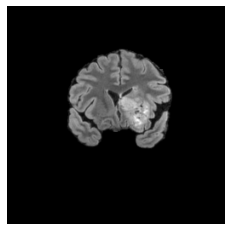

In [7]:
data_directory = '/content/train/'
def load_dicom_images_3d(scan_id, num_imgs=NUM_IMAGES, img_size=SIZE, mri_type="FLAIR", split="train", rotate=0):
    files = sorted(glob.glob(f"{data_directory}/{split}/{scan_id}/{mri_type}/*.dcm"), 
               key=lambda var:[int(x) if x.isdigit() else x for x in re.findall(r'[^0-9]|[0-9]+', var)])
    middle = len(files)//2
    num_imgs2 = num_imgs//2
    p1 = max(0, middle - num_imgs2)
    p2 = min(len(files), middle + num_imgs2)
    img3d = np.stack([load_dicom_image(f, rotate=rotate) for f in files[p1:p2]]).T 
    if img3d.shape[-1] < num_imgs:
        n_zero = np.zeros((img_size, img_size, num_imgs - img3d.shape[-1]))
        img3d = np.concatenate((img3d,  n_zero), axis = -1)
    if np.min(img3d) < np.max(img3d):
        img3d = img3d - np.min(img3d)
        img3d = img3d / np.max(img3d)
            
    return np.expand_dims(img3d,0)

a = load_dicom_images_3d("00000")

array([[-32756.25537634, -32756.25537634, -32756.25537634, ...,
        -32756.25537634, -32756.25537634, -32756.25537634],
       [-32756.25537634, -32756.25537634, -32756.25537634, ...,
        -32756.25537634, -32756.25537634, -32756.25537634],
       [-32756.25537634, -32756.25537634, -32756.25537634, ...,
        -32756.25537634, -32756.25537634, -32756.25537634],
       ...,
       [-32756.25537634, -32756.25537634, -32756.25537634, ...,
        -32756.25537634, -32756.25537634, -32756.25537634],
       [-32756.25537634, -32756.25537634, -32756.25537634, ...,
        -32756.25537634, -32756.25537634, -32756.25537634],
       [-32756.25537634, -32756.25537634, -32756.25537634, ...,
        -32756.25537634, -32756.25537634, -32756.25537634]])

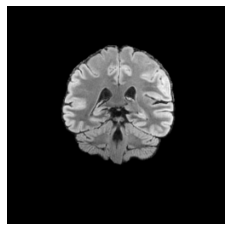

In [8]:
load_dicom_image('/content/train/train/00000/FLAIR/Image-155.dcm')

In [9]:
def load_dicom(path):
    dicom=pydicom.read_file(path)
    data=dicom.pixel_array
    data=data-np.min(data)
    if np.max(data) != 0:
        data=data/np.max(data)
    data=(data*255).astype(np.uint8)
    return data

In [10]:
train_df= pd.read_csv('/content/train/train_labels.csv')
sample_df = pd.read_csv('/content/train/sample_submission.csv')
train_df.head()

,BraTS21ID,MGMT_value
0,0,1
1,2,1
2,3,0
3,5,1
4,6,1


In [13]:
!rm -rf /content/train/test

In [14]:
batch_size = 32
img_height = 75
img_width = 75

train_dir='/content/train/train'
trainset=[]
trainlabel=[]
for i in range(len(train_df)):
    idt=train_df.loc[i,'BraTS21ID']
    idt2=('00000'+str(idt))[-5:]
    path=os.path.join(train_dir,idt2,'T1wCE')
    for im in os.listdir(path):
        img=load_dicom(os.path.join(path,im))#Carga
        img=cv2.resize(img,(img_height,img_width))
        image=img_to_array(img)
        image=image/255.0 #Normalizacion
        trainset+=[image]
        trainlabel+=[train_df.loc[i,'MGMT_value']]

In [15]:
X_train, X_test, y_train, y_test = train_test_split(trainset, trainlabel, test_size=0.2, random_state=33)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=33)

In [16]:
train_ds =validation_data=tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(batch_size)
val_ds =validation_data=tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(batch_size)
test_ds =validation_data=tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(batch_size)

In [17]:
for image, label in train_ds.unbatch():
  print(label)

Streaming output truncated to the last 5000 lines.
tf.Tensor(0, shape=(), dtype=int32)
tf.Tensor(0, shape=(), dtype=int32)
tf.Tensor(1, shape=(), dtype=int32)
tf.Tensor(0, shape=(), dtype=int32)
tf.Tensor(1, shape=(), dtype=int32)
tf.Tensor(1, shape=(), dtype=int32)
tf.Tensor(0, shape=(), dtype=int32)
tf.Tensor(0, shape=(), dtype=int32)
tf.Tensor(0, shape=(), dtype=int32)
tf.Tensor(0, shape=(), dtype=int32)
tf.Tensor(1, shape=(), dtype=int32)
tf.Tensor(0, shape=(), dtype=int32)
tf.Tensor(0, shape=(), dtype=int32)
tf.Tensor(1, shape=(), dtype=int32)
tf.Tensor(1, shape=(), dtype=int32)
tf.Tensor(0, shape=(), dtype=int32)
tf.Tensor(0, shape=(), dtype=int32)
tf.Tensor(1, shape=(), dtype=int32)
tf.Tensor(1, shape=(), dtype=int32)
tf.Tensor(0, shape=(), dtype=int32)
tf.Tensor(1, shape=(), dtype=int32)
tf.Tensor(0, shape=(), dtype=int32)
tf.Tensor(1, shape=(), dtype=int32)
tf.Tensor(0, shape=(), dtype=int32)
tf.Tensor(1, shape=(), dtype=int32)
tf.Tensor(0, shape=(), dtype=int32)
tf.Tensor(0, 

In [18]:
base_model = InceptionV3(
    input_shape=(img_height, img_width, 1),
    include_top=False,
    weights=None,
)

base_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 75, 75, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 37, 37, 32)   288         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 37, 37, 32)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 activation (Activation)        (None, 37, 37, 32)   0           ['batch_normalization[

In [19]:
clf = Sequential(name='Red_con_Conocimiento')

clf.add(base_model)
clf.add(GlobalAveragePooling2D(name='Pooling'))
clf.add(Dense(50, activation="relu", name='Dense_1'))
clf.add(Dense(10, activation="relu", name='Dense_2'))
clf.add(Dense(1, activation="softmax", name='Dense_out'))

clf.compile(
    optimizer='adam',
    loss="binary_crossentropy",
    metrics=["acc",tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall')]
)

clf.summary()
my_callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_recall', patience=3, mode='max')
]

Model: "Red_con_Conocimiento"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 1, 1, 2048)        21802208  
                                                                 
 Pooling (GlobalAveragePooli  (None, 2048)             0         
 ng2D)                                                           
                                                                 
 Dense_1 (Dense)             (None, 50)                102450    
                                                                 
 Dense_2 (Dense)             (None, 10)                510       
                                                                 
 Dense_out (Dense)           (None, 1)                 11        
                                                                 
Total params: 21,905,179
Trainable params: 21,870,747
Non-trainable params: 34,432
_____________________________

In [20]:
with tf.device('/device:GPU:0'): 
    history = clf.fit(train_ds,
        validation_data=val_ds,
        epochs=50,
        callbacks=my_callbacks
    )

Epoch 1/50
1936/1936 [==============================] - 119s 52ms/step - loss: 0.6914 - acc: 0.5399 - precision: 0.5399 - recall: 1.0000 - val_loss: 0.6878 - val_acc: 0.5377 - val_precision: 0.5377 - val_recall: 1.0000
Epoch 2/50
1936/1936 [==============================] - 98s 50ms/step - loss: 0.6871 - acc: 0.5399 - precision: 0.5399 - recall: 1.0000 - val_loss: 0.6860 - val_acc: 0.5377 - val_precision: 0.5377 - val_recall: 1.0000
Epoch 3/50
1936/1936 [==============================] - 98s 50ms/step - loss: 0.6875 - acc: 0.5399 - precision: 0.5399 - recall: 1.0000 - val_loss: 0.6957 - val_acc: 0.5377 - val_precision: 0.5377 - val_recall: 1.0000
Epoch 4/50
1936/1936 [==============================] - 98s 50ms/step - loss: 0.6892 - acc: 0.5399 - precision: 0.5399 - recall: 1.0000 - val_loss: 0.6913 - val_acc: 0.5377 - val_precision: 0.5377 - val_recall: 1.0000


In [21]:
img_height

75

In [22]:
y_true = list()
y_pred = list()

for images, labels in train_ds:
    pred = clf.predict(images)
    for i in range(len(pred)):
        y_true.append(labels[i].numpy())
        y_pred.append((pred[i] == pred[i].max()).astype(int))

y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_true, y_pred

1/1 [==============================] - 1s 1s/step


(array([1, 1, 1, ..., 1, 1, 1], dtype=int32), array([[1],
        [1],
        [1],
        ...,
        [1],
        [1],
        [1]]))

In [25]:
print(classification_report(y_true,y_pred,target_names=list(['0','1'])))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00     28496
           1       0.54      1.00      0.70     33433

    accuracy                           0.54     61929
   macro avg       0.27      0.50      0.35     61929
weighted avg       0.29      0.54      0.38     61929



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [27]:
def plot_metrics_training_validation(history):
  plt.plot(history.history['recall'], label='Training recall')
  plt.plot(history.history['val_recall'], label='Test recall')
  plt.plot(history.history['precision'], label='Training precision')
  plt.plot(history.history['val_precision'], label='Test precision')
  plt.title('Training and validation metrics')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()
  plt.show()

In [34]:
clf = Sequential(name='Red_con_Conocimiento')

clf.add(base_model)
clf.add(GlobalAveragePooling2D(name='Pooling'))
clf.add(Dense(32768, activation="relu", name='Dense_0'))
clf.add(Dense(16384, activation="relu", name='Dense_1'))
clf.add(Dense(8192, activation="relu", name='Dense_2'))
clf.add(Dense(4096, activation="relu", name='Dense_3'))
clf.add(Dense(2048, activation="relu", name='Dense_4'))
clf.add(Dense(1024, activation="relu", name='Dense_5'))
clf.add(Dense(512, activation="relu", name='Dense_6'))
clf.add(Dense(256, activation="relu", name='Dense_7'))
clf.add(Dense(128, activation="relu", name='Dense_8'))
clf.add(Dense(64, activation="relu", name='Dense_9'))
clf.add(Dense(32, activation="relu", name='Dense_10'))
clf.add(Dense(16, activation="relu", name='Dense_11'))
clf.add(Dense(8, activation="relu", name='Dense_12'))
clf.add(Dense(1, activation="softmax", name='Dense_out'))

clf.compile(
    optimizer='adam',
    loss="binary_crossentropy",
    metrics=["acc",tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall')]
)

clf.summary()
my_callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_recall', patience=3, mode='max')
]
with tf.device('/device:GPU:0'): 
    history = clf.fit(train_ds,
        validation_data=val_ds,
        epochs=50,
        callbacks=my_callbacks
    )

Model: "Red_con_Conocimiento"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 1, 1, 2048)        21802208  
                                                                 
 Pooling (GlobalAveragePooli  (None, 2048)             0         
 ng2D)                                                           
                                                                 
 Dense_0 (Dense)             (None, 32768)             67141632  
                                                                 
 Dense_1 (Dense)             (None, 16384)             536887296 
                                                                 
 Dense_2 (Dense)             (None, 8192)              134225920 
                                                                 
 Dense_3 (Dense)             (None, 4096)              33558528  
                                              

In [35]:
y_true = list()
y_pred = list()

for images, labels in train_ds:
    pred = clf.predict(images)
    for i in range(len(pred)):
        y_true.append(labels[i].numpy())
        y_pred.append((pred[i] == pred[i].max()).astype(int))

y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_true, y_pred

1/1 [==============================] - 1s 1s/step


(array([1, 1, 1, ..., 1, 1, 1], dtype=int32), array([[1],
        [1],
        [1],
        ...,
        [1],
        [1],
        [1]]))

In [36]:
print(classification_report(y_true,y_pred,target_names=list(['0','1'])))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00     28496
           1       0.54      1.00      0.70     33433

    accuracy                           0.54     61929
   macro avg       0.27      0.50      0.35     61929
weighted avg       0.29      0.54      0.38     61929



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


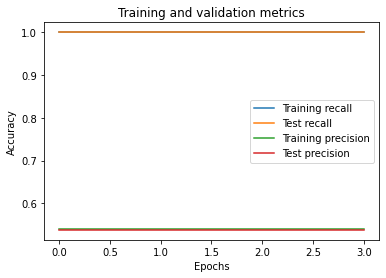

In [28]:
plot_metrics_training_validation(history)

In [29]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 18439411929641404796
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 40231960576
locality {
  bus_id: 1
  links {
  }
}
incarnation: 1061595200844022082
physical_device_desc: "device: 0, name: A100-SXM4-40GB, pci bus id: 0000:00:04.0, compute capability: 8.0"
xla_global_id: 416903419
]


In [ ]:
#Resnet50

In [ ]:
base_model = applications.resnet.ResNet50(weights= None, include_top=False, input_shape= (img_height,img_width,1))
x = base_model.output
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.7)(x)
predictions = keras.layers.Dense(2, activation= 'softmax')(x)
model = keras.models.Model(inputs = base_model.input, outputs = predictions)
# model.summary()
model.compile(optimizer='RMSprop', loss='binary_crossentropy', metrics=['accuracy'])
with tf.device('/device:GPU:0'): 
    history = model.fit(train_ds,
        validation_data=val_ds,
        epochs=50,
        callbacks=my_callbacks
    )
#TODO: fix input